# Final Project (15.062) - Predicting Airbnb Prices across the US

##### *Michele Marinucci, MIT Master of Finance 2021*

### Data loading

In [256]:
#load packages and clean environment
%reset -f
import numpy as np
import pandas as pd
import matplotlib.pylab as plt; plt.style.use('ggplot')
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,StackingRegressor
from sklearn import tree
from sklearn.neighbors import NearestNeighbors,KNeighborsRegressor
from dmba import regressionSummary
import statsmodels.api as sm
import warnings; warnings.filterwarnings("ignore")
import plotly.io as pio
import plotly.graph_objects as go
from IPython.display import Image

#load data
data=pd.read_csv('AB_US_2020.csv', low_memory=False)

#show raw data
data.head(4)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,NaN,28804,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville
1,80905,French Chic Loft,427027,Celeste,NaN,28801,35.59779,-82.55540,Entire home/apt,470,1,114,07/09/20,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,NaN,28801,35.60670,-82.55563,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.57864,-82.59578,Entire home/apt,90,1,267,22/09/20,2.39,5,0,Asheville


## Data pre-processing and variable exploration 

#### Set meaningful index

In [257]:
# set proper index
data=data.set_index([data.id]).drop(columns=['id'])
data=data.sort_index()

#### Variable transformation

In [258]:
#set last review to date datatype
data.last_review=pd.to_datetime(data.last_review)

#transform it into "days since last review"
data.last_review=(data.last_review.max()-data.last_review)/np.timedelta64(1,'D')

#### Missing data, outliers and useless data

In [259]:
#drop useless data
data.drop(columns=['name','host_name','host_id','neighbourhood_group','neighbourhood'],inplace=True)

In [260]:
#study missing data
print("Columns with missing values:",', '.join(data.columns[data.apply(lambda x: pd.isna(x).sum())!=0].tolist()),".")

Columns with missing values: last_review, reviews_per_month .


In [261]:
#Fill NaN with median
data.last_review=data.last_review.fillna(data.last_review.median())
data.reviews_per_month=data.reviews_per_month.fillna(data.reviews_per_month.median())

In [262]:
#check for outliers
data.apply(sorted) #shows top and bottom outliers

,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
id,,,,,,,,,,,
109,18.92099,-159.71490,Entire home/apt,0,1,0,0.0,0.01,1,0,Asheville
177,18.92950,-159.71428,Entire home/apt,0,1,0,0.0,0.01,1,0,Asheville
344,18.98232,-159.71143,Entire home/apt,0,1,0,0.0,0.01,1,0,Asheville
360,18.98310,-159.70731,Entire home/apt,0,1,0,0.0,0.01,1,0,Asheville
364,18.98361,-159.70570,Entire home/apt,0,1,0,0.0,0.01,1,0,Asheville
...,...,...,...,...,...,...,...,...,...,...,...
45516412,47.73360,-71.00212,Shared room,24999,1125,910,3390.0,27.71,593,365,Washington D.C.
45517735,47.73361,-71.00200,Shared room,24999,1125,950,3488.0,29.12,593,365,Washington D.C.
45541369,47.73385,-71.00155,Shared room,24999,1125,951,3490.0,32.43,593,365,Washington D.C.


In [263]:
#delete observation with clear upper-bound outlier in minimum nights
data=data[data.minimum_nights<1e7]

#### Split features and labels

In [264]:
#split in X,y 
X=data.drop(columns='price')
y=data['price']

#### Check data types

In [265]:
#list categoricals and numericals
pd.DataFrame({'dtypes':X.dtypes})

,dtypes
latitude,float64
longitude,float64
room_type,object
minimum_nights,int64
number_of_reviews,int64
last_review,float64
reviews_per_month,float64
calculated_host_listings_count,int64
availability_365,int64
city,object


In [266]:
#create lists of numericals and categoricals
categoricals=['city', 'room_type']
numericals=list(set(X.columns)-set(categoricals))
print('categoricals:',', '.join(categoricals),'\n\nnumericals:',', '.join(numericals))

categoricals: city, room_type 

numericals: latitude, reviews_per_month, longitude, availability_365, number_of_reviews, minimum_nights, last_review, calculated_host_listings_count


#### Handle and explore categoricals

In [267]:
#set as categorical
X[categoricals]=X[categoricals].astype('category')
pd.DataFrame({'dtypes':X[categoricals].dtypes})

,dtypes
city,category
room_type,category


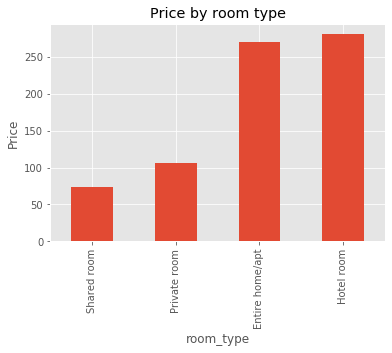

In [268]:
#plot categoricals: room_type
data.groupby(by='room_type').mean()['price'].sort_values().plot.bar()
plt.title('Price by room type')
plt.ylabel('Price')
plt.show()

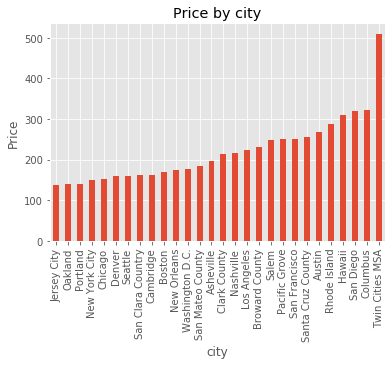

In [269]:
#price by city
data.groupby(by='city').mean()['price'].sort_values().plot.bar()
plt.title('Price by city')
plt.ylabel('Price')
plt.show()

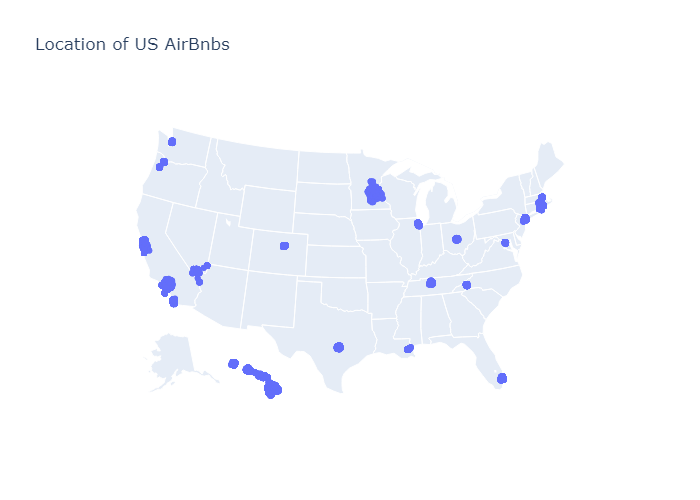

In [270]:
#show on map
fig = go.Figure(data=go.Scattergeo(lon = X['longitude'],lat = X['latitude'],mode = 'markers'))
fig.update_layout(title = "Location of US AirBnbs",geo_scope='usa')
Image(pio.to_image(fig, format='png'))

In [271]:
#get dummies (drop first)
X=pd.get_dummies(X,drop_first=True)

#### Handle and explore numericals


In [272]:
#standardize numericals
X.loc[:,numericals]=X[numericals].apply(lambda x: (x-x.mean())/x.std())
X.head()

,latitude,longitude,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,room_type_Hotel room,room_type_Private room,...,city_Rhode Island,city_Salem,city_San Clara Country,city_San Diego,city_San Francisco,city_San Mateo County,city_Santa Cruz County,city_Seattle,city_Twin Cities MSA,city_Washington D.C.
id,,,,,,,,,,,,,,,,,,,,,
109,-0.245367,-0.578304,0.786899,-0.511086,3.592519,-0.844564,-0.307400,0.026284,0,0,...,0,0,0,0,0,0,0,0,0,0
177,0.588775,-0.065031,-0.361562,0.369375,-0.583831,-0.031611,-0.268237,1.167677,0,0,...,0,0,0,0,0,0,0,0,0,0
344,-0.218574,-0.576384,-0.321960,-0.416751,0.118240,-0.758642,-0.307400,-1.136511,0,0,...,0,0,0,0,0,0,0,0,0,0
360,0.599166,-0.067957,-0.282358,1.312726,-0.778080,2.546044,-0.287819,-0.858296,0,0,...,0,0,0,0,0,0,0,0,0,0
364,0.598944,-0.067060,6.925225,0.825328,3.645244,-0.434783,-0.307400,0.996468,0,0,...,0,0,0,0,0,0,0,0,0,0


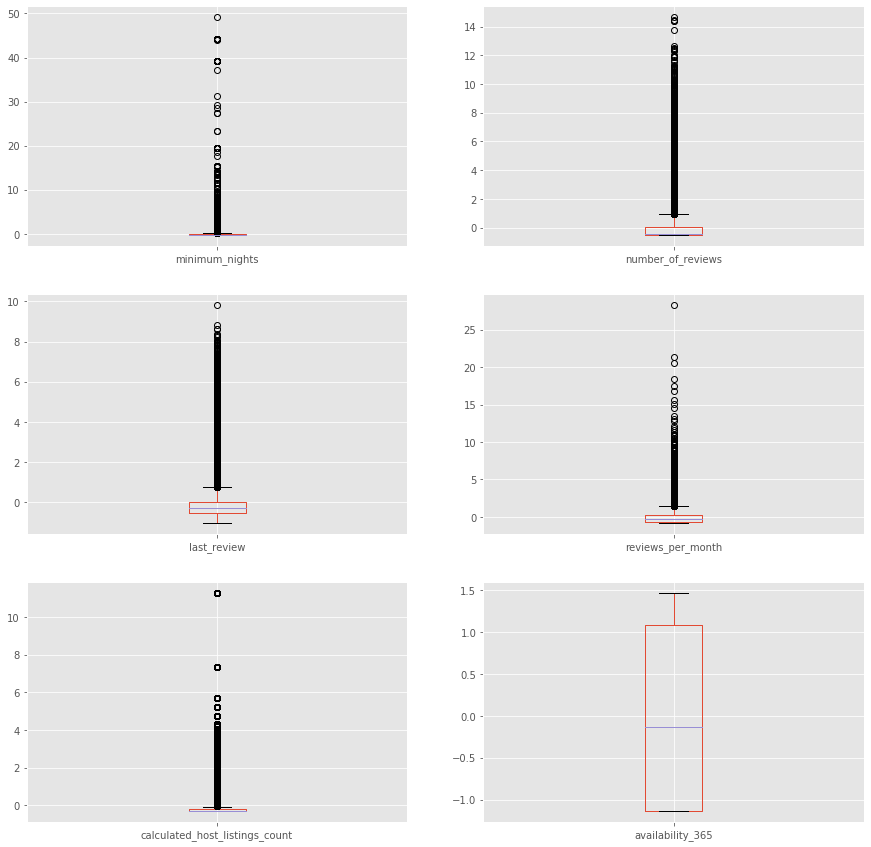

In [273]:
## side-by-side boxplots
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(15,15))
X.boxplot(column='minimum_nights', ax=axes[0,0])
X.boxplot(column='number_of_reviews', ax=axes[0,1])
X.boxplot(column='last_review',ax=axes[1,0])
X.boxplot(column='reviews_per_month', ax=axes[1,1])
X.boxplot(column='calculated_host_listings_count', ax=axes[2,0])
X.boxplot(column='availability_365', ax=axes[2,1])
plt.show()

#some variables have very right skewed distributions

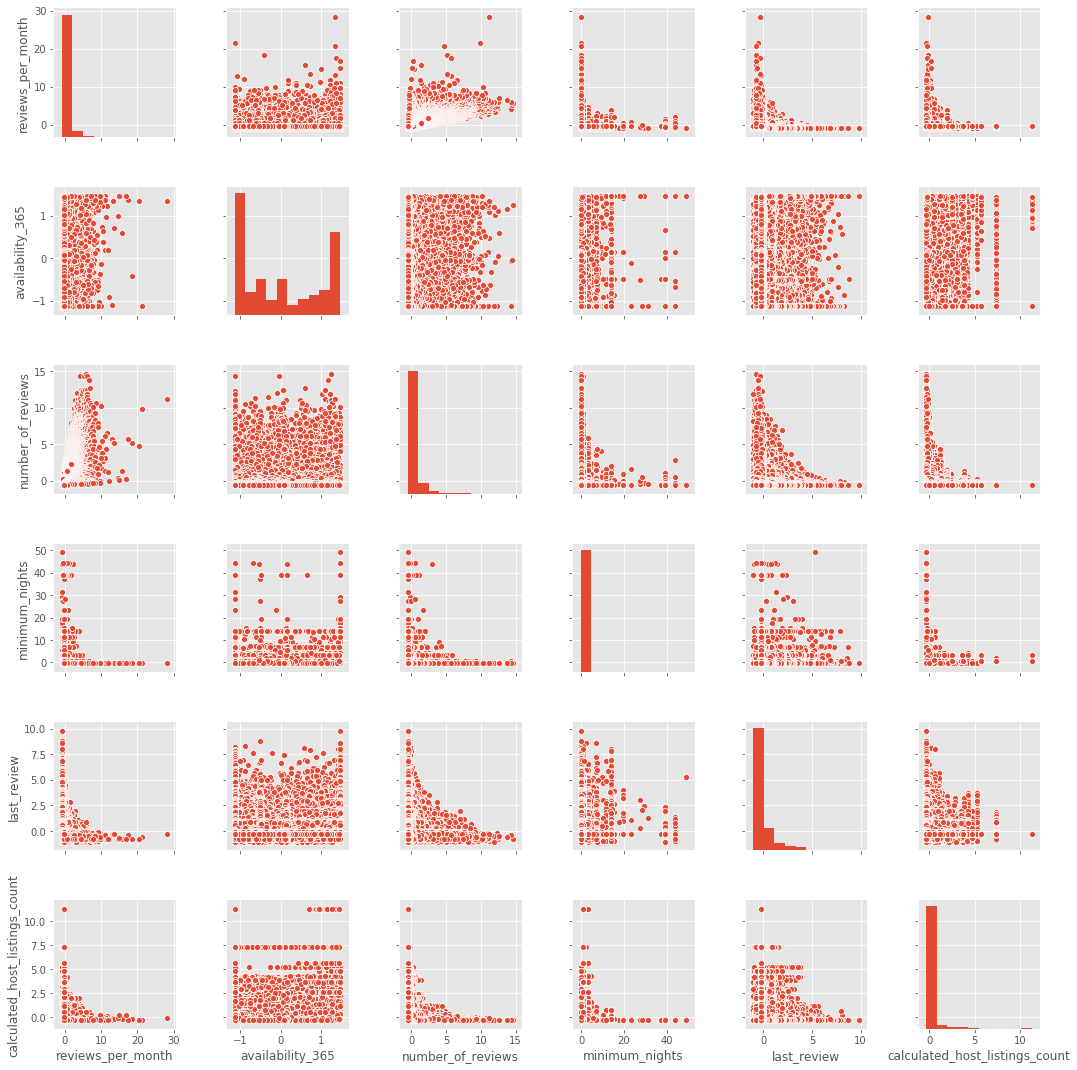

In [274]:
#visualize numericals
sns.pairplot(X[list(set(numericals)-set(['latitude','longitude']))])
plt.show()

#there may be a hint of linear correlation among reviews per month and number of reviews; below I will investigate this further

#### Correlation analysis

In [275]:
# correlation matrix among all variables
corr=X.corr()

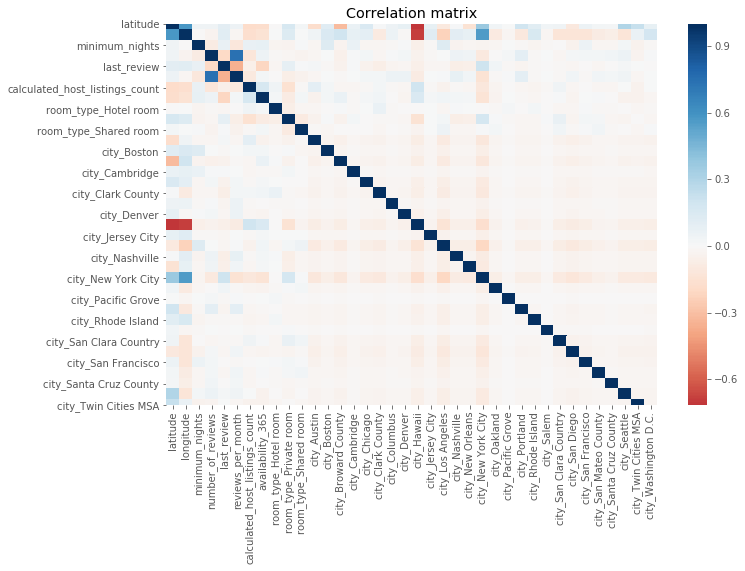

In [276]:
#correlation matrix heatmap
fig, ax = plt.subplots()
fig.set_size_inches(11, 7)
sns.heatmap(corr, annot=False, fmt='.1f', cmap='RdBu', center=0,ax=ax)
plt.title('Correlation matrix')
plt.show()

#high correlations (>0.5) between:
#new york and longitude
#hawaii and longitude latitude
#number of reviews and reviews per month

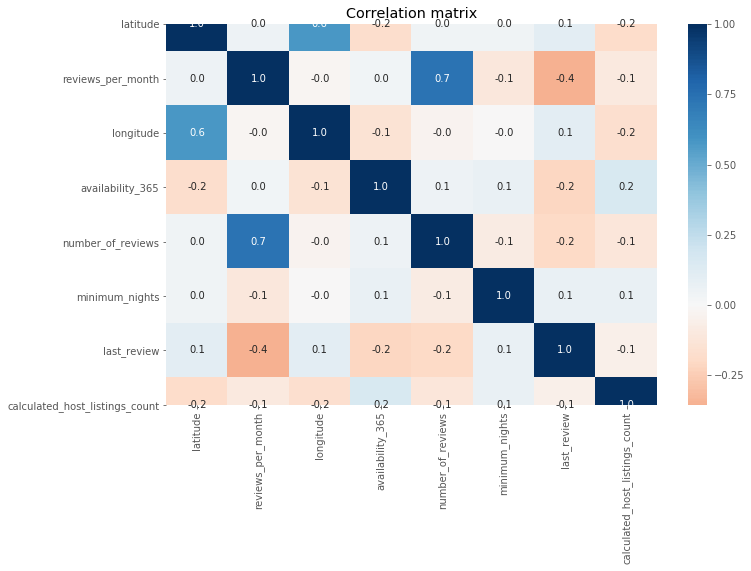

In [277]:
# correlation matrix among numerical variables
corr=X[numericals].corr()
fig, ax = plt.subplots()
fig.set_size_inches(11, 7)
sns.heatmap(corr, annot=True, fmt='.1f', cmap='RdBu', center=0,ax=ax)
plt.title('Correlation matrix')
plt.show()

In [278]:
#given both heatmaps above, drop reviews per month and longitude
X.drop(columns=['reviews_per_month','longitude'], inplace=True)
numericals=list(set(numericals)-set(['reviews_per_month','longitude']))

#### Principal component analysis

In [279]:
#apply PCA on numericals, which are 6
pcs = PCA(n_components=6)
pcs.fit(X[numericals])
pcsSummary = pd.DataFrame({'Standard deviation':np.sqrt(pcs.explained_variance_),
                          'Proportion of variance': pcs.explained_variance_ratio_,
                          'Cumulative proportion': np.cumsum(pcs.explained_variance_ratio_)})
pcsSummary = pcsSummary.transpose()
pcsSummary.round(4)
pcsSummary.columns = ['PC{}'.format(i) for i in range(1,len(pcsSummary.columns) + 1)]
pcsSummary

,PC1,PC2,PC3,PC4,PC5,PC6
Standard deviation,1.208459,1.126625,1.005937,0.888867,0.867984,0.845548
Proportion of variance,0.243396,0.211547,0.168652,0.131681,0.125566,0.119158
Cumulative proportion,0.243396,0.454943,0.623595,0.755275,0.880842,1.000000


First two components account for over 45% of total variability.

In [280]:
pcsComponents_df = pd.DataFrame(pcs.components_.transpose(),
                                columns=['PC{}'.format(i) for i in range(1,len(pcsSummary.columns) + 1)],
                                index=list(numericals))
pcsComponents_df

,PC1,PC2,PC3,PC4,PC5,PC6
latitude,-0.491815,-0.159523,0.448349,-0.572009,-0.406759,-0.197499
availability_365,0.577282,0.003723,0.283365,0.246375,-0.462415,-0.558486
number_of_reviews,0.101687,-0.661621,0.256357,-0.041339,0.625494,-0.305364
minimum_nights,0.027915,0.403747,0.796928,0.197212,0.259374,0.308135
last_review,-0.473118,0.441517,-0.099965,0.236671,0.277339,-0.662042
calculated_host_listings_count,0.435778,0.422903,-0.088774,-0.717977,0.292035,-0.150312


In [281]:
scores = pd.DataFrame(pcs.transform(X[list(numericals)]),
                      columns=['PC{}'.format(i) for i in range(1,len(pcsSummary.columns) + 1)])
scores

,PC1,PC2,PC3,PC4,PC5,PC6
0,-1.727801,2.151250,0.061684,1.394093,0.878646,-1.899872
1,0.571308,-0.851151,0.483583,-0.081259,-0.882434,-0.565778
2,-0.789855,0.098581,-0.767992,0.047442,0.213284,0.673874
3,-0.421854,-1.546560,0.240263,-0.641644,0.601193,0.431532
4,-1.300675,3.637585,5.944281,2.317952,2.529248,-1.160021
...,...,...,...,...,...,...
226024,0.593112,0.238578,0.876340,0.287574,-1.236578,-0.378922
226025,-0.682331,-0.017732,-0.167705,-0.305603,-0.407022,0.654727
226026,-0.590168,-0.029610,-0.605423,-0.110023,-0.161696,0.819723
226027,0.418989,-0.020417,-0.121909,0.326887,-0.956306,-0.145018


Principal components analysis (PCA) is a useful method for
dimension reduction, especially when the number of variables is large.
PCA is especially valuable when we have subsets of measurements that
are measured on the same scale and are highly correlated. In that case,
it provides a few variables (often as few as three) that are weighted
linear combinations of the original variables, and that retain the
183
majority of the information of the full original set. PCA is intended for
use with numerical variables.

One disadvantage of using a subset of principal components as
predictors in a supervised task, is that we might lose predictive
information that is nonlinear (e.g., a quadratic effect of a predictor on
the outcome variable or an interaction between predictors). This is
because PCA produces linear transformations, thereby capturing
linear relationships between the original variables.


#### Final data types and missing values check

In [282]:
#check missing data and data types again
assert X.columns[X.apply(lambda x: pd.isna(x).sum())!=0].tolist()==[] #make sure there are no NaN
pd.DataFrame({'dtypes':X.dtypes})

,dtypes
latitude,float64
minimum_nights,float64
number_of_reviews,float64
last_review,float64
calculated_host_listings_count,float64
availability_365,float64
room_type_Hotel room,uint8
room_type_Private room,uint8
room_type_Shared room,uint8
city_Austin,uint8


#### Show processed data

In [283]:
#show processed data
X.head(7)

,latitude,minimum_nights,number_of_reviews,last_review,calculated_host_listings_count,availability_365,room_type_Hotel room,room_type_Private room,room_type_Shared room,city_Austin,...,city_Rhode Island,city_Salem,city_San Clara Country,city_San Diego,city_San Francisco,city_San Mateo County,city_Santa Cruz County,city_Seattle,city_Twin Cities MSA,city_Washington D.C.
id,,,,,,,,,,,,,,,,,,,,,
109,-0.245367,0.786899,-0.511086,3.592519,-0.307400,0.026284,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
177,0.588775,-0.361562,0.369375,-0.583831,-0.268237,1.167677,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
344,-0.218574,-0.321960,-0.416751,0.118240,-0.307400,-1.136511,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
360,0.599166,-0.282358,1.312726,-0.778080,-0.287819,-0.858296,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
364,0.598944,6.925225,0.825328,3.645244,-0.307400,0.996468,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
590,0.597207,-0.361562,8.890981,-0.553306,-0.287819,0.019150,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
592,0.597319,-0.242756,2.287522,-0.214758,-0.287819,-1.136511,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Predictory and eplanatory models

#### Reduce size of data
I am reducicing size of data to 10%, otherwise it would be quite prohibitive to run the following models on my machine given the large dataset.

In [284]:
#reduce data set to 10%
print(f'Size of original data:{len(X)}\nSize of current data:{int(len(X)*.1)}')
X=X.join(y)
X=X.sample(frac=0.2, random_state=1)
y=X['price']
X=X.drop(columns='price')

#split in train and test again
train_X, valid_X, train_y, valid_y = train_test_split(X, y,test_size=0.3,random_state=1)

Size of original data:226029
Size of current data:22602


#### Define model evaluation function
I evaluate all models below based on RMSE on both train and validation sets.

In [285]:
def evaluate(estimator,train_X,train_y,valid_X,valid_y):
    print('------------------------------------------------\nTraining results')
    regressionSummary(train_y, estimator.predict(train_X))
    print('------------------------------------------------\nValidation results')
    regressionSummary(valid_y, estimator.predict(valid_X))
    print('------------------------------------------------')

#### Baseline - Multiple linear regression

In [286]:
#linear model on training set
train_X2 = sm.add_constant(train_X)
baseline = sm.OLS(train_y,train_X2).fit()
baseline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     42.06
Date:                Wed, 09 Dec 2020   Prob (F-statistic):          7.33e-288
Time:                        16:54:21   Log-Likelihood:            -2.4318e+05
No. Observations:               31644   AIC:                         4.864e+05
Df Residuals:                   31607   BIC:                         4.868e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            207.1626     31.221      6.635      0.000     145.968     268.357
latitude                         230.1360     77.974      2.951      0.003      77.304     382.968
minimum_nights                    -7.7366      2.949     -2.623      0.009     -13.518      -1.955
number_of_reviews                -42.8911      3.121    -13.742      0.000     -49.009     -36.774
last_review                       -5.6782      3.138     -1.809      0.070     -11.829       0.473
calculated_host_listings_count     8.3750      3.201      2.616      0.009       2.100      14.650
availability_365                  11.4348      3.130      3.654      0.000       5.300      17.569
room_type_Hotel room             -19.7854     33.695     -0.587      0.557     -85.828      46.258
room_type_Private room          -153.4850      6.842    -22.433      0.000    -166.896    -140.074
room_type_Shared room           -210.5658     21.953     -9.592      0.000    -253.594    -167.537
city_Austin                      268.3017     69.316      3.871      0.000     132.440     404.163
city_Boston                     -210.6965     86.722     -2.430      0.015    -380.675     -40.718
city_Broward County              369.9849    113.131      3.270      0.001     148.244     591.726
city_Cambridge                  -190.8942     94.839     -2.013      0.044    -376.783      -5.006
city_Chicago                    -216.2420     80.318     -2.692      0.007    -373.668     -58.816
city_Clark County                 23.5681     35.355      0.667      0.505     -45.728      92.864
city_Columbus                   -158.1478     69.233     -2.284      0.022    -293.846     -22.449
city_Denver                     -142.7514     60.721     -2.351      0.019    -261.767     -23.736
city_Hawaii                      621.8791    170.608      3.645      0.000     287.481     956.277
city_Jersey City                -192.9756     72.569     -2.659      0.008    -335.213     -50.738
city_Los Angeles                 133.9378     36.650      3.654      0.000      62.102     205.773
city_Nashville                    14.7933     36.358      0.407      0.684     -56.469      86.056
city_New Orleans                 182.6375     73.238      2.494      0.013      39.087     326.188
city_New York City              -153.8329     66.796     -2.303      0.021    -284.756     -22.910
city_Oakland                     -64.2531     47.280     -1.359      0.174    -156.925      28.418
city_Pacific Grove                38.3904    119.766      0.321      0.749    -196.355     273.136
city_Portland                   -342.8192    119.388     -2.871      0.004    -576.824    -108.815
city_Rhode Island                -79.9264     78.317     -1.021      0.307    -233.430      73.577
city_Salem    

The stats at the bottom indicate very high skewness and kurtosis, which together with the JB stat indicate that data is not normally distributed at all. 

In [287]:
#check performance on scikit learn
reg = LinearRegression().fit(train_X, train_y)
evaluate(reg,train_X,train_y,valid_X,valid_y)

------------------------------------------------
Training results

Regression statistics

               Mean Error (ME) : -0.0000
Root Mean Squared Error (RMSE) : 526.3877
     Mean Absolute Error (MAE) : 159.7354
------------------------------------------------
Validation results

Regression statistics

               Mean Error (ME) : 4.7988
Root Mean Squared Error (RMSE) : 586.2224
     Mean Absolute Error (MAE) : 165.6278
------------------------------------------------


In [352]:
#save best linear regression
best_reg=LinearRegression()

#### Decision tree

In [289]:
# user grid search to find optimized tree
param_grid = {'max_depth': [5, 10, 15, 20, 25],
              'min_impurity_decrease': [0, 0.005, 0.01,0.1],
              'min_samples_split': [1, 10, 20, 30, 40, 50]}
gridSearch = GridSearchCV(DecisionTreeRegressor(),
                          param_grid,
                          cv=4,
                          n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Initial parameters:', gridSearch.best_params_)

Initial parameters: {'max_depth': 5, 'min_impurity_decrease': 0, 'min_samples_split': 20}


In [290]:
param_grid = {'max_depth': [2,3,4,5,6,7,8,9],
              'min_impurity_decrease': [0.001, 0.003, 0.005,0.007],
              'min_samples_split': [22,25, 28, 30, 32, 35,37]}
gridSearch = GridSearchCV(DecisionTreeRegressor(),
                          param_grid,
                          cv=4,
                          n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Improved parameters: ', gridSearch.best_params_)
regTree = gridSearch.best_estimator_

Improved parameters:  {'max_depth': 6, 'min_impurity_decrease': 0.001, 'min_samples_split': 22}


In [291]:
evaluate(regTree,train_X,train_y,valid_X,valid_y)

------------------------------------------------
Training results

Regression statistics

               Mean Error (ME) : -0.0000
Root Mean Squared Error (RMSE) : 475.1194
     Mean Absolute Error (MAE) : 143.4669
------------------------------------------------
Validation results

Regression statistics

               Mean Error (ME) : 3.9319
Root Mean Squared Error (RMSE) : 534.3187
     Mean Absolute Error (MAE) : 148.8721
------------------------------------------------


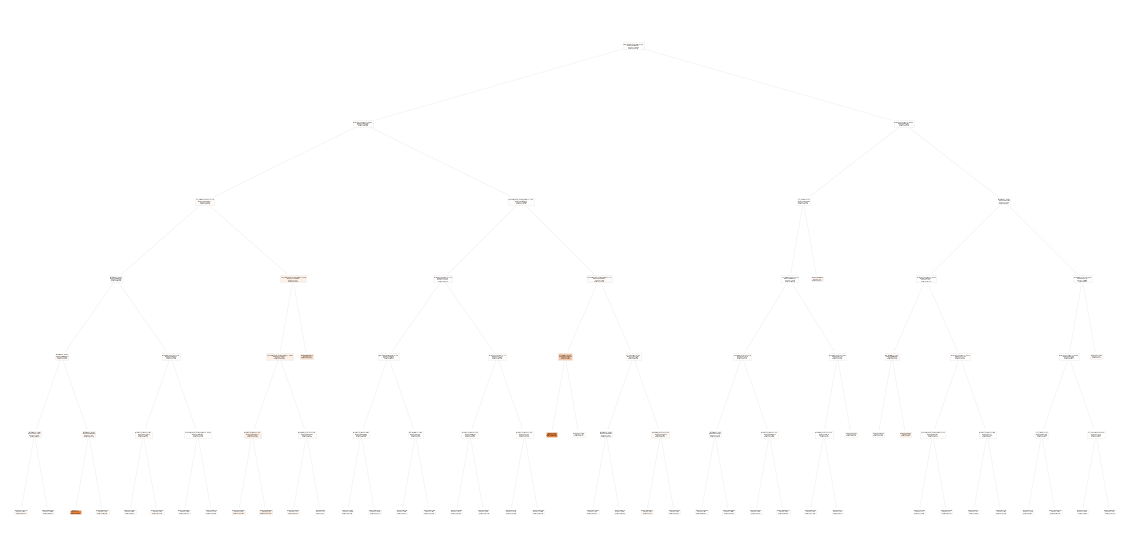

In [292]:
fig = plt.figure(figsize=(20,10))
tree.plot_tree(regTree, feature_names=X.columns, filled=True)
plt.show()

In [350]:
#save best tree
best_tree=regTree

#### Random forest

In [293]:
# Create the random grid
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 10, stop =2000, num = 10)],
               'max_features': ['sqrt','log2'],
               'max_depth': [int(x) for x in np.linspace(start = 2, stop =20 , num = 10)],
               'min_samples_split': [10,50,100],
               'min_samples_leaf': [10,50,100],
               'bootstrap': [True, False]}
print(random_grid)

{'n_estimators': [10, 231, 452, 673, 894, 1115, 1336, 1557, 1778, 2000], 'max_features': ['sqrt', 'log2'], 'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20], 'min_samples_split': [10, 50, 100], 'min_samples_leaf': [10, 50, 100], 'bootstrap': [True, False]}


In [294]:
# First create the base model to tune
rf = RandomForestRegressor()

# Use the random grid to search for best hyperparameters
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 20,
                               cv = 4,
                               verbose=2, 
                               random_state=42,
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(train_X, train_y)
rf_random.best_params_

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  5.6min finished


{'n_estimators': 894,
 'min_samples_split': 100,
 'min_samples_leaf': 10,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': False}

In [295]:
evaluate(rf_random,train_X,train_y,valid_X,valid_y)

------------------------------------------------
Training results

Regression statistics

               Mean Error (ME) : 0.0000
Root Mean Squared Error (RMSE) : 474.3135
     Mean Absolute Error (MAE) : 134.7614
------------------------------------------------
Validation results

Regression statistics

               Mean Error (ME) : 6.2637
Root Mean Squared Error (RMSE) : 552.2468
     Mean Absolute Error (MAE) : 145.5908
------------------------------------------------


Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with GridSearchCV, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define. To use Grid Search, we make another grid based on the best values provided by random search:


In [297]:
# Create the parameter grid based on the results of random search 
param_grid = {'bootstrap': [False],
              'max_depth': [15,17,20,23,25],
              'max_features': ['sqrt'],
              'min_samples_leaf': [8,10,12],
              'min_samples_split': [90,100,110,120],
              'n_estimators': [800,900,1000]}

# Create a base model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf,
                           param_grid = param_grid,
                           cv = 4,
                           n_jobs = -1,
                           verbose = 2)
# Fit the random search model
grid_search.fit(train_X, train_y)
grid_search.best_params_

Fitting 4 folds for each of 180 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 41.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 78.4min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 89.3min finished


{'bootstrap': False,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 8,
 'min_samples_split': 90,
 'n_estimators': 900}

In [298]:
#fit and analyze performance of this best random forest
best_grid = grid_search.best_estimator_
evaluate(best_grid,train_X,train_y,valid_X,valid_y)

------------------------------------------------
Training results

Regression statistics

               Mean Error (ME) : 0.0000
Root Mean Squared Error (RMSE) : 467.7809
     Mean Absolute Error (MAE) : 133.2799
------------------------------------------------
Validation results

Regression statistics

               Mean Error (ME) : 6.1481
Root Mean Squared Error (RMSE) : 548.8343
     Mean Absolute Error (MAE) : 144.8862
------------------------------------------------


In [299]:
# variable (feature) importance plot
importances = best_grid.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_grid.estimators_], axis=0)
importance_df = pd.DataFrame({'feature': train_X.columns,
                   'importance':importances,
                   'std': std})
importance_df = importance_df.sort_values('importance')
importance_df

,feature,importance,std
24,city_Pacific Grove,7.172985e-07,0.000009
12,city_Cambridge,3.835912e-05,0.000098
31,city_San Mateo County,1.939280e-04,0.000159
15,city_Columbus,2.713176e-04,0.000355
27,city_Salem,2.772185e-04,0.000613
32,city_Santa Cruz County,2.953570e-04,0.000272
18,city_Jersey City,4.164466e-04,0.000550
10,city_Boston,4.529178e-04,0.000824
16,city_Denver,5.905389e-04,0.000729
6,room_type_Hotel room,6.378719e-04,0.000995


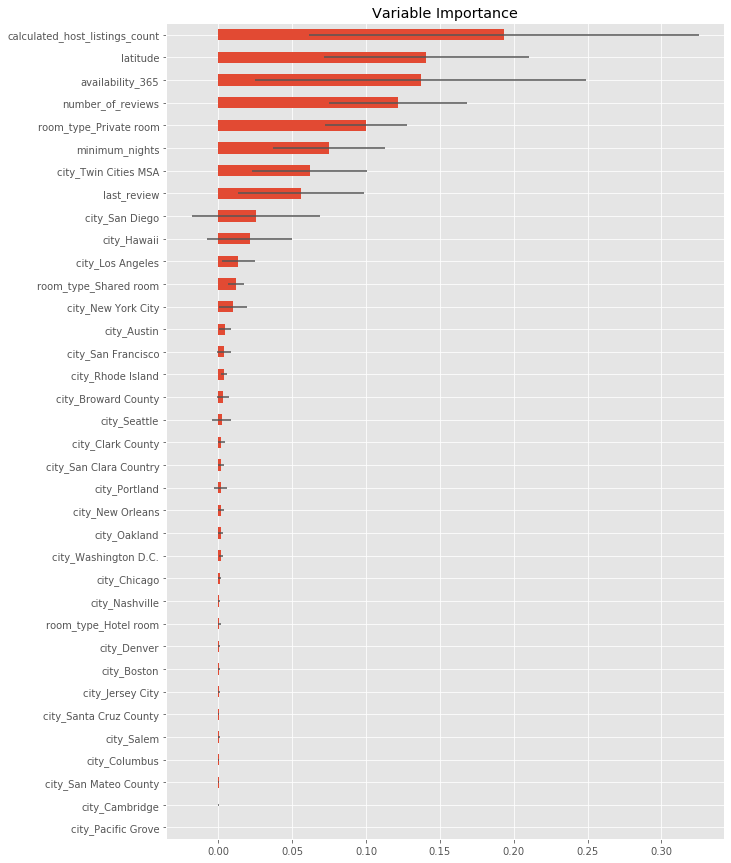

In [345]:
#plot
ax = importance_df.plot(kind='barh', xerr='std', x='feature', legend=False,figsize=(10,15))
ax.set_ylabel('')
plt.title('Variable Importance')
plt.show()

In [349]:
#save best random forest
best_rf=best_grid

#### K-Nearest Neighbours for regression

In [ ]:
# Train a classifier for different values of k, extracting corresponding RMSE
results = []
for k in [3,10,100,500,1000,2000,5000]:
    knn = KNeighborsRegressor(n_neighbors=k).fit(train_X,train_y)
    results.append({'k': k,'RMSE': (((valid_y-knn.predict(valid_X))**2).sum()/len(valid_y))**.5})

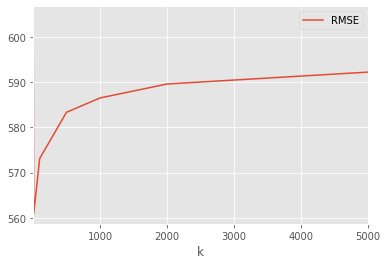

,k,RMSE
0,3,604.615676
1,10,560.839229
2,100,573.100196
3,500,583.345766
4,1000,586.517516
5,2000,589.607074
6,5000,592.244945


In [316]:
# look for best k
pd.DataFrame(results).plot('k','RMSE')
plt.show();pd.DataFrame(results)

In [319]:
# Given these results, zoom in for values of k close to 10
results = []
for k in [4,5,6,7,8,9,10,12,15,17,20]:
    knn = KNeighborsRegressor(n_neighbors=k).fit(train_X,train_y)
    results.append({'k': k,'RMSE': (((valid_y-knn.predict(valid_X))**2).sum()/len(valid_y))**.5})

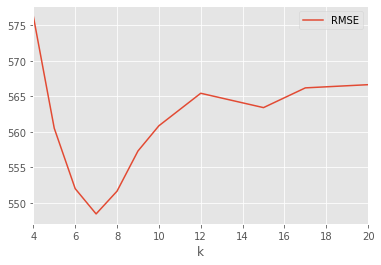

,RMSE
k,
4,576.263504
5,560.493532
6,551.992074
7,548.431394
8,551.635106
9,557.287595
10,560.839229
12,565.418531
15,563.398688


In [329]:
# look for best k
pd.DataFrame(results).plot('k','RMSE'); plt.show()
knn_result=pd.DataFrame(results)
knn_result.set_index('k')

In [348]:
#save best knn
best_knn=KNeighborsRegressor(n_neighbors=4)

#### Ensemble

Here is a brief overview of the estimators used so far along with their best parameters.

In [353]:
best_tree

DecisionTreeRegressor(max_depth=6, min_impurity_decrease=0.001,
                      min_samples_split=22)

In [354]:
best_reg

LinearRegression()

In [355]:
best_rf

RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                      min_samples_leaf=8, min_samples_split=90,
                      n_estimators=900)

In [356]:
best_knn

KNeighborsRegressor(n_neighbors=4)

In [358]:
#select estimators to use in ensemble
estimators = [('reg', best_reg),
              ('rf',best_rf),
              ('knn',best_knn)]

In [360]:
#create ensemble
ensemble = StackingRegressor(estimators=estimators,
                        final_estimator=best_tree)

In [362]:
#fit ensemble
ensemble.fit(train_X, train_y)

StackingRegressor(estimators=[('reg', LinearRegression()),
                              ('rf',
                               RandomForestRegressor(bootstrap=False,
                                                     max_depth=20,
                                                     max_features='sqrt',
                                                     min_samples_leaf=8,
                                                     min_samples_split=90,
                                                     n_estimators=900)),
                              ('knn', KNeighborsRegressor(n_neighbors=4))],
                  final_estimator=DecisionTreeRegressor(max_depth=6,
                                                        min_impurity_decrease=0.001,
                                                        min_samples_split=22))

In [363]:
#compute RMSE
(((valid_y-ensemble.predict(valid_X))**2).sum()/len(valid_y))**.5

555.0054362094288

#### Summary of results

In [364]:
final_results={'K-Nearest Neighbors':548.4,'Random Forest':548.8,'Linear Regression':586.2,'Decision Tree':534.3,'Ensemble':555.0}
final_results=pd.DataFrame({'Model':[i for i in final_results.keys()],'RMSE':[i for i in final_results.values()]})
final_results.set_index('Model').sort_values('RMSE')

,RMSE
Model,
Decision Tree,534.3
K-Nearest Neighbors,548.4
Random Forest,548.8
Ensemble,555.0
Linear Regression,586.2
